In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import date

In [3]:
from data_preprocessing import *

settings = {
    'directory': '/data/rainbolt/sh4b/mixed_selection_p5855/background/',
    'n_seeds': 25,
    'trigger_tag': 'orLR2bXj',
    'model_tag': "tol0p001",
    'sig_region': '2dfit',
    'trig': 'LR_2b1j',
    'info': '95contour',
}

truth_X, truth_S, sig_hists, bkg_hists, bkg_hists_up, bkg_hists_dw = prepare_hist_all(settings)

Getting signals from /data/rainbolt/sh4b/mixed_selection_p5855/signal/
for 2018 , mc20e , with trigger LR_2b1j
Getting signals from /data/rainbolt/sh4b/mixed_selection_p5855/signal/
for 2017 , mc20d , with trigger LR_2b1j
Getting signals from /data/rainbolt/sh4b/mixed_selection_p5855/signal/
for 2016 , mc20a , with trigger LR_2b1j
Getting background


/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Getting backgrounds for year = 2016
Getting backgrounds for year = 2017
Getting backgrounds for year = 2018


In [19]:
truth_X

[200, 300, 400, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000]

In [20]:
truth_S

[70,
 100,
 170,
 200,
 250,
 300,
 400,
 500,
 750,
 1000,
 1500,
 2000,
 2500,
 3000,
 4000,
 5000]

In [4]:
save_name = f'{settings["trig"]}_{settings["sig_region"]}_seeds{settings["n_seeds"]}_{settings["info"]}_{date.today().strftime("%Y-%m-%d")}'
print('Saving with', save_name)

Saving with LR_2b1j_2dfit_seeds25_95contour_2025-01-20


In [ ]:
import numpy as np

def optimize_binning(signal_hist, background_hist, min_events=10, min_s_over_sqrt_b=2):
    """
    Optimizes binning for signal and background histograms.
    
    Parameters:
        signal_hist (tuple): Tuple of (counts, bin_edges) for the signal histogram.
        background_hist (tuple): Tuple of (counts, bin_edges) for the background histogram.
        min_events (int): Minimum number of events per bin.
        min_s_over_sqrt_b (float): Minimum signal significance per bin.

    Returns:
        np.ndarray: Optimized bin edges.
    """
    signal_counts, bin_edges = signal_hist
    background_counts, _ = background_hist

    # Initialize the current binning
    current_bins = list(bin_edges)
    new_bin_edges = [current_bins[0]]

    # Combine bins iteratively
    combined_signal = signal_counts[0]
    combined_background = background_counts[0]

    for i in range(1, len(signal_counts)):
        combined_signal += signal_counts[i]
        combined_background += background_counts[i]
        
        # Calculate significance
        if combined_background > 0:
            significance = combined_signal / np.sqrt(combined_background)
        else:
            significance = float('inf')  # Avoid division by zero
        
        # Check if the bin meets the criteria
        if (
            combined_signal + combined_background >= min_events 
            and significance >= min_s_over_sqrt_b
        ):
            # Start a new bin
            new_bin_edges.append(current_bins[i])
            combined_signal = 0
            combined_background = 0

    # Add the last bin edge
    new_bin_edges.append(current_bins[-1])

    return np.array(new_bin_edges)

# Example Usage
# Fine-binned signal and background histograms (counts, bin_edges)
signal_hist = (np.array([1, 2, 1, 3, 8, 5]), np.array([0, 1, 2, 3, 4, 5, 6]))
background_hist = (np.array([5, 4, 5, 2, 1, 0]), np.array([0, 1, 2, 3, 4, 5, 6]))

optimized_bins = optimize_binning(signal_hist, background_hist, min_events=5, min_s_over_sqrt_b=1.5)
print("Optimized Bin Edges:", optimized_bins)


In [22]:
# settings['info'] = 'TEST'
# settings
# save_name = f'{settings["trig"]}_{settings["sig_region"]}_seeds{settings["n_seeds"]}_{settings["info"]}_{date.today().strftime("%Y-%m-%d")}'
# print('Saving with', save_name)

In [23]:
from fitter import Fitter

def run_fit(truth_S, truth_X, sig_hists, bkg_hists, bkg_hists_up, bkg_hists_dw, name='', quick=False):
    exp_limits = []

    for S in truth_S:

        exp_limits_s = []

        for X in truth_X:

            key = f'{X}_{S}'
            
            # print(key)

            sig = sig_hists.get(key, None)
            bkg = bkg_hists.get(key, None)
            bkg_hists_up_ = bkg_hists_up.get(key, None)
            bkg_hists_dw_ = bkg_hists_dw.get(key, None)

            if sig is None or bkg is None:
                # print('-> Signal is None')
                exp_limits_s.append(np.inf)
                continue
                
            # print(S, X)
            if (S not in [400, 500] or X not in [2000]) and quick:
            # if (S not in [500] or X not in [1500]) and quick:
                # print('->')
                exp_limits_s.append(np.inf)
                continue

            print(f'Fitting X = {X}, S = {S}')

            bins = sig[1]
            
            sig     = ak.to_numpy(sig[0])
            bkg     = ak.to_numpy(bkg[0])
            bkg_hists_up_ = ak.to_numpy(bkg_hists_up_[0])
            bkg_hists_dw_ = ak.to_numpy(bkg_hists_dw_[0])

            fitter = Fitter(sig, bkg, bins, X, S, debug=False, save_dir=f'plots_fit_{name}/')
            
            fitter.set_bkg_vars(bkg_hists_up_, bkg_hists_dw_)
        
            fitter.prepare_fit(plot_summary=True)

            obs_limit, exp_limit = fitter.fit(poi_values=np.linspace(0.01, 350, 500))
            print(f'    exp_limit = {exp_limit}')

            exp_limits_s.append(float(exp_limit))

        exp_limits.append(exp_limits_s)
        
    exp_limits = np.array(exp_limits)
    
    np.savez(f'plots_fit_{name}/saved_limits', exp_limits)

    return exp_limits

In [24]:
exp_limits = run_fit(truth_S, truth_X, sig_hists, bkg_hists, bkg_hists_up, bkg_hists_dw, name=save_name, quick=False)
# exp_limits_saved = np.array(exp_limits)
# np.savez(f'./saved_limits_{save_name}', exp_limits_saved)

Fitting X = 300, S = 70
    exp_limit = 350.0
Fitting X = 400, S = 70
    exp_limit = 350.0
Fitting X = 750, S = 70
    exp_limit = 67.59655783231784
Fitting X = 1000, S = 70
    exp_limit = 111.15222972009781
Fitting X = 1500, S = 70
    exp_limit = 90.84575283167683
Fitting X = 2000, S = 70
    exp_limit = 52.547911378902185
Fitting X = 2500, S = 70
    exp_limit = 30.75803657391942
Fitting X = 3000, S = 70
    exp_limit = 21.958066417828412
Fitting X = 300, S = 100
    exp_limit = 350.0
Fitting X = 400, S = 100
    exp_limit = 350.0
Fitting X = 750, S = 100
    exp_limit = 18.467259625720338
Fitting X = 1000, S = 100
    exp_limit = 13.247679697745461
Fitting X = 1500, S = 100
    exp_limit = 15.404720351023704
Fitting X = 2000, S = 100
    exp_limit = 17.702419233973636
Fitting X = 2500, S = 100
    exp_limit = 15.651612349589216
Fitting X = 3000, S = 100
    exp_limit = 12.362587964593601
Fitting X = 4000, S = 100
    exp_limit = 8.843724681058582
Fitting X = 5000, S = 100
    exp

In [25]:
# exp_limits_saved

In [26]:
labels_x = []
labels_s = []
for x in sorted(set(truth_X)):
    labels_x.append(str(x))
for s in sorted(set(truth_S)):
    labels_s.append(str(s))

In [27]:
from plotting_tools import annotate_heatmap
from matplotlib.colors import LogNorm

labels_x = []
labels_s = []
for x in sorted(set(truth_X)):
    labels_x.append(str(x))
for s in sorted(set(truth_S)):
    labels_s.append(str(s))
        
def plot_limits(exp_limits,
                name='',
                title='',
                cbar_label='95% CL Upper Limit on Cross Section [fb]',
                cmap='Blues',
                color_threshold=0.5,
                comparison=False):
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))

    if not comparison:
        im = ax.imshow(exp_limits, cmap=cmap, norm=LogNorm(vmin=0.1, vmax=350))
    else:
        im = ax.imshow(exp_limits, cmap=cmap, vmin=-100, vmax=100)

    texts = annotate_heatmap(im, data=None, valfmt="{x:.1f}", threshold=color_threshold,
                             fontsize=9, ha="center", va="center")

    cbar = ax.figure.colorbar(im)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")
    cbar.set_label(cbar_label, rotation=90, size=15, labelpad=15)

    #Show all ticks and label them with the respective list entries

    ax.set_xticks(np.arange(len(labels_x)), labels=labels_x)
    ax.set_yticks(np.arange(len(labels_s)), labels=labels_s)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_xlabel('$m_{X}$ [GeV]', fontsize=18)
    ax.set_ylabel('$m_{S}$ [GeV]', fontsize=18)
    ax.set_title(title, fontsize=14, loc='right')

    fig.tight_layout()
    print("Saving... plots_fit" +"/"+  "Limits_NF_" + name + '.pdf')
    plt.savefig("plots_fit" +"/"+  "Limits_NF_" + name + '.pdf')
    plt.show()

In [28]:
# limits_NF_LR_2b1j     = np.load(f'plots_fit_{save_name}/saved_limits.npz')

# exp_limits_NF_LR_2b1j = limits_NF_LR_2b1j['arr_0']

In [29]:
print(exp_limits.shape)
print(len(labels_x), len(labels_s))

(16, 12)
12 16


Saving... plots_fit/Limits_NF_LR_2b1j_2dfit_seeds25_95contour_2025-01-13.pdf


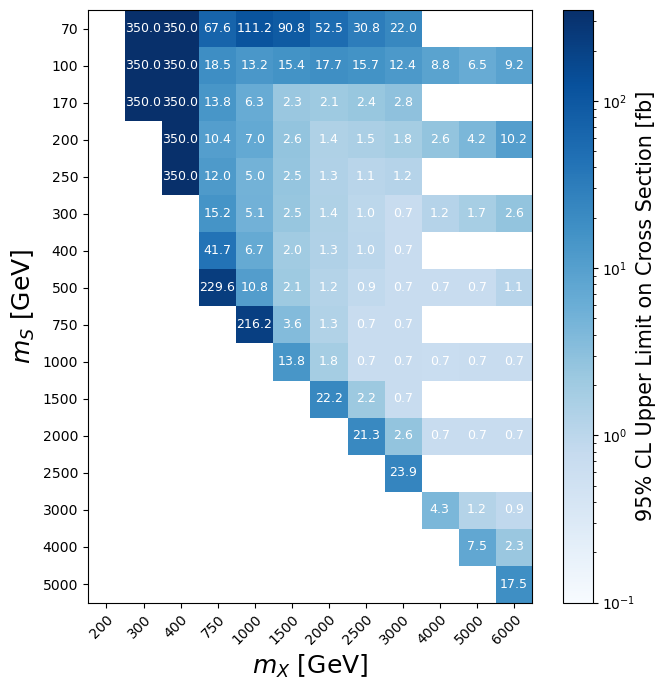

In [30]:
plot_limits(exp_limits, name=save_name)

In [ ]:
limits_1d     = np.load(f'plots_fit_LR_2b1j_1dfit_seeds25_latest_files_2025-01-09/saved_limits.npz')
exp_limits_1d = limits_1d['arr_0']

limits_2d_99     = np.load(f'plots_fit_LR_2b1j_2dfit_seeds25_latest_files_2025-01-09/saved_limits.npz')
exp_limits_2d_99 = limits_2d['arr_0']

limits_None     = np.load(f'plots_fit_LR_2b1j_None_seeds25_latest_files_2025-01-09/saved_limits.npz')
exp_limits_None = limits_None['arr_0']

limits_2d_68     = np.load(f'plots_fit_LR_2b1j_2dfit_seeds25_latest_68contour_2025-01-13/saved_limits.npz')
exp_limits_2d_68 = limits_2d['arr_0']

limits_2d_95     = np.load(f'plots_fit_LR_2b1j_2dfit_seeds25_latest_95contour_2025-01-13/saved_limits.npz')
exp_limits_2d_95 = limits_2d['arr_0']


/tmp/ipykernel_185/2877163979.py:1: RuntimeWarning: invalid value encountered in subtract
  perc_diff = (exp_limits_2d_95 - exp_limits_1d) / exp_limits_1d * 100


Saving... plots_fit/Limits_NF_2d_95_vs_1D_perc_diff_13Jan.pdf


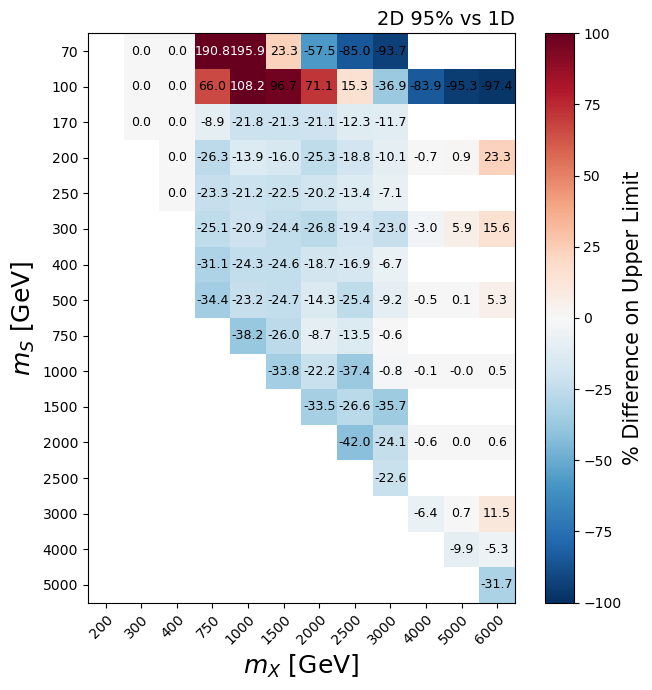

In [44]:
perc_diff = (exp_limits_2d_95 - exp_limits_1d) / exp_limits_1d * 100
plot_limits(perc_diff, name='2d_95_vs_1D_perc_diff_13Jan',
            title='2D 95% vs 1D',
            cbar_label='% Difference on Upper Limit',
            cmap='RdBu_r',
            color_threshold=100,
            comparison=True)